In [1]:
import sys
sys.path.append("..") 
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from PIL import Image
import os
import shutil
import subprocess
from tqdm import tqdm

from utils.shapefiles import sampleShapefileLocations
from utils.divtree_gen import *
from utils.seqdata_gen import *
from utils.seq2demodst import *
from utils.coords import *
from utils.noise import *
from utils.metrics import *
from analysis.peaksdata import *

%matplotlib inline
mpl.rcParams['image.cmap'] = 'terrain'

In [2]:
np.random.seed(42)

In [3]:
promEpsilon   = 30   # m,  minimum prominence threshold in the analysis
diskRadius    = 30   # km, used for the analysis to normalize histograms 
globalMaxElev = 9000 # m,  any value larger than any other peak elevation, used internally as initialization and undefineds

terrainUnitKm  = 90  # km, size of terrain
km2pixels = 1000/30  # 30 m/pixel

# process each region (note: it takes a long time!)
regionShapesDir = 'data/regionShapes'
regionPeaksDir = 'data/regionPeaks'
regionSeqsDir = 'data/regionSeqs'
regionTreeSeqsDir = 'data/regionTreeSeqs'


regionShapes = ['andes_peru.shp']

In [4]:
#regionName, filterCoords = 'pyrenees', [42.5893, 0.9377] # pyrenees: aiguestortes
#regionName, filterCoords = 'alps', [45.8325,  7.0]  # mont blanc
#regionName, filterCoords = 'alps', [44.8742,  6.5]  # ecrins
#regionName, filterCoords = 'alps', [46.4702, 11.9492] # dolomites
#regionName, filterCoords = 'alps', [46.0159, 7.74318] # valais
#regionName, filterCoords = 'sahara', [30.38, 8.69] # sahara dunes
#regionName, filterCoords = 'andes_chile', [-21.4483, -68.0708] # chile
#regionName, filterCoords = 'karakoram', [35.8283, 76.3608] # karakoram
#regionName, filterCoords = 'colorado', [39.0782,-106.6986] # colorado
#regionName, filterCoords = 'yangshuo', [24.9917, 110.4617] # yangshuo
#regionName, filterCoords = 'himalaya', [28.7150, 84.2000] # himalaya: annapurna
#regionName, filterCoords = 'himalaya', [27.8575, 86.8267] # himalaya: everest
#regionName, filterCoords = 'norway', [62.1167, 6.8075] # norway
#regionName, filterCoords = 'alaska', [62.9500, -151.0908] # alaska
#regionName, filterCoords = 'patagonia', [-50.8925, -73.1533] # patagonia
#regionName, filterCoords = 'andes_aconcagua', [-32.6533, -70.0108] # aconcagua
regionName, filterCoords = 'andes_peru', [-9.0874, -77.5737] # huascaran
#regionName, filterCoords = 'rockies', [50.8003, -116.29517] # canadian rockies
#regionName, filterCoords = 'appalachians', [35.3855, -83.2380] # appalachians
#regionName, filterCoords = 'highlands', [56.9667, -3.5917] # highlands

peaksFile = '../data/regionPeaks/%s.csv' % regionName

filterRadius = 45 # km
filterHWidth = [km2deg(filterRadius), km2deg(filterRadius, filterCoords[0])]
print("filter scope: ",filterCoords[0] - filterHWidth[0], filterCoords[0] + filterHWidth[0],
      filterCoords[1] - filterHWidth[1], filterCoords[1] + filterHWidth[1])

# read peaks file and filter region of interest
df = pd.read_csv(peaksFile)

filat = np.logical_and(df['latitude']  > filterCoords[0] - filterHWidth[0], 
                       df['latitude'] < filterCoords[0] + filterHWidth[0])
filon = np.logical_and(df['longitude'] > filterCoords[1] - filterHWidth[1], 
                       df['longitude'] < filterCoords[1] + filterHWidth[1])
df = df[np.logical_and(filat, filon)]

print('Peaks:', df.shape[0])

filter scope:  -9.49232387431163 -8.682476125688371 -77.98377085251597 -77.16362914748403
Peaks: 1057


### Visualize the peaks

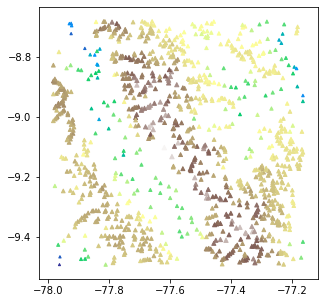

In [5]:
# compute distributions
df = addExtraColumns(df)
fig = plt.figure(figsize=(5,5))
_ = plt.scatter(df['longitude'], df['latitude'], marker='^', 
                s=20*df['elev'].values/df['elev'].values.max(), c=df['elev'].values/df['elev'].values.max())

### Generrate Sequence

In [6]:
rootNode = genDivideTree(df)
seqOfTree = genFullSeqMCMC(rootNode, isDFS=True)

In [7]:
print(len(seqOfTree))
Y = [] # Next node
X = [] # Last node
for peakpair in seqOfTree:
    X.append(list(peakpair[0][1:]))
    Y.append(list(peakpair[1][1:]))
X = np.array(X)
Y = np.array(Y)

1057


x' ~ x


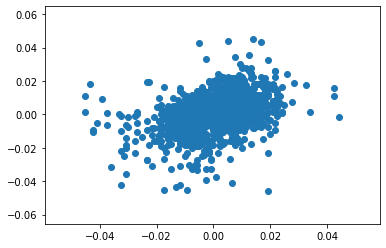

x' ~ y


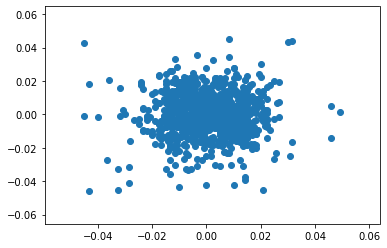

x' ~ ele


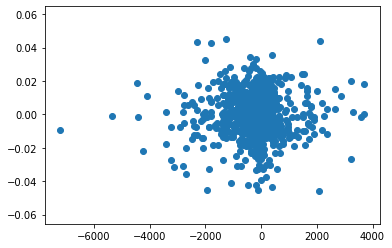

x' ~ pro


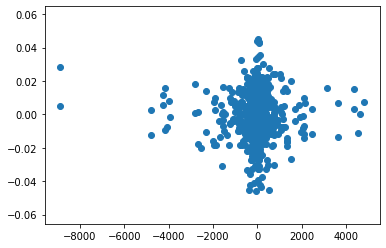

In [8]:
# position deltas x distribution
print("x' ~ x")
plt.scatter(X[:,0], Y[:,0])
plt.show()
print("x' ~ y")
plt.scatter(X[:,1], Y[:,0])
plt.show()
print("x' ~ ele")
plt.scatter(X[:,2], Y[:,0])
plt.show()
print("x' ~ pro")
plt.scatter(X[:,3], Y[:,0])
plt.show()

y' ~ x


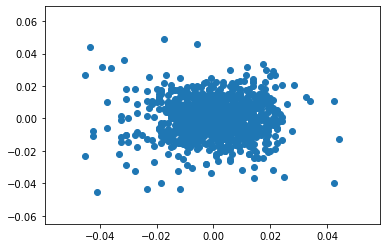

y' ~ y


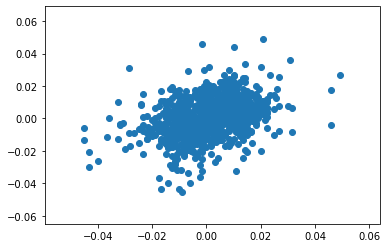

y' ~ ele


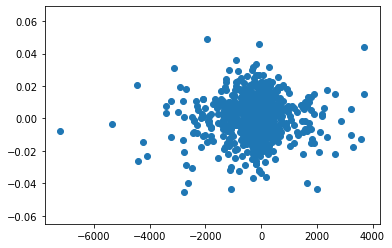

y' ~ pro


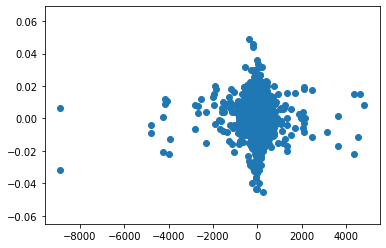

In [9]:
# position deltas y distribution
print("y' ~ x")
plt.scatter(X[:,0], Y[:,1])
plt.show()
print("y' ~ y")
plt.scatter(X[:,1], Y[:,1])
plt.show()
print("y' ~ ele")
plt.scatter(X[:,2], Y[:,1])
plt.show()
print("y' ~ pro")
plt.scatter(X[:,3], Y[:,1])
plt.show()

ele' ~ x


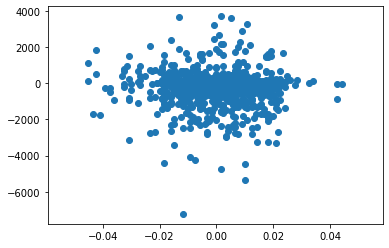

ele' ~ y


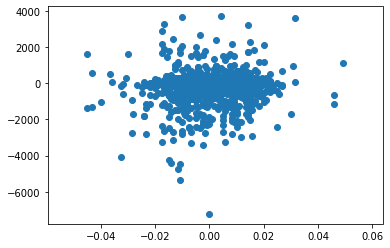

ele' ~ ele


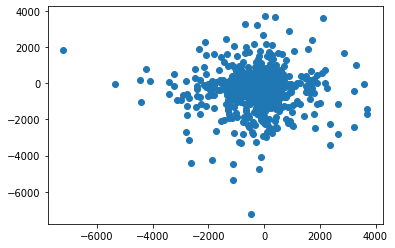

ele' ~ pro


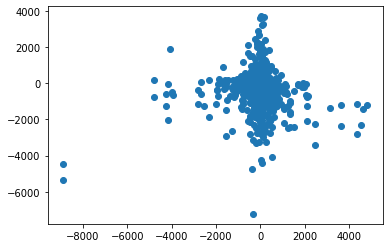

In [10]:
# position deltas ele distribution
print("ele' ~ x")
plt.scatter(X[:,0], Y[:,2])
plt.show()
print("ele' ~ y")
plt.scatter(X[:,1], Y[:,2])
plt.show()
print("ele' ~ ele")
plt.scatter(X[:,2], Y[:,2])
plt.show()
print("ele' ~ pro")
plt.scatter(X[:,3], Y[:,2])
plt.show()

pro' ~ x


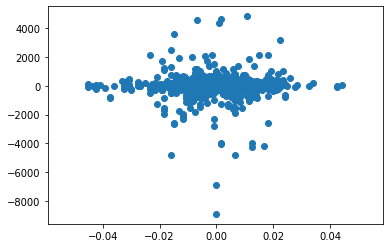

pro' ~ y


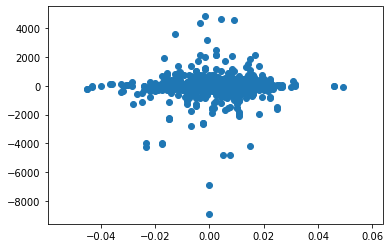

pro' ~ ele


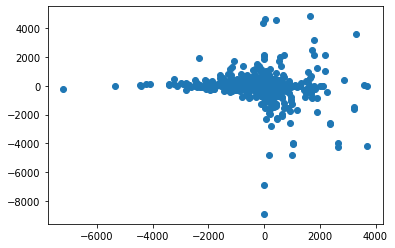

pro' ~ pro


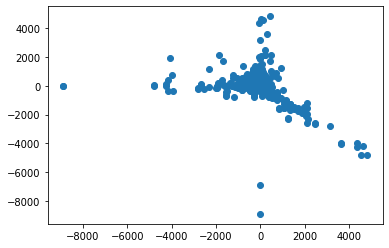

In [11]:
# position deltas pro distribution
print("pro' ~ x")
plt.scatter(X[:,0], Y[:,3])
plt.show()
print("pro' ~ y")
plt.scatter(X[:,1], Y[:,3])
plt.show()
print("pro' ~ ele")
plt.scatter(X[:,2], Y[:,3])
plt.show()
print("pro' ~ pro")
plt.scatter(X[:,3], Y[:,3])
plt.show()

The shape of the distribution looks like a gaussion distribution relative with the input value

### Proir Guese

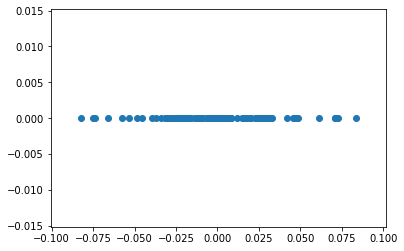

In [12]:
mu = 0
sigma = 0.03
shape = 100
yt = np.zeros(shape)
xt = np.random.normal(mu, sigma, shape )
plt.scatter(xt,yt)

sigma is around 0.03  
mu is arounf 0.0

### define model (pymc)

In [13]:
import pymc3 as pm
# Y Next node data
# X Last node data

In [14]:
datastd = np.std(X, axis=0)
datamax = np.amax(X, axis=0)

In [15]:
def getParaMCMC(X, Y, i, datamax, datastd):
    with pm.Model() as my_model:
    # Create the sigma1, sigma2, mu1, mu2, rho parameters
        sigma1 = pm.Normal('sigma1', mu=datastd[i], tau=0.001)
        
        lambda1 = pm.Normal('lambda1', mu=0.0, tau=0.005)
        lambda2 = pm.Normal('lambda2', mu=0.0, tau=0.005)
        lambda3 = pm.Normal('lambda3', mu=0.0, tau=0.005)
        lambda4 = pm.Normal('lambda4', mu=0.0, tau=0.005)

        mu1 = pm.Normal('mu1', mu=0.0, tau=0.002)

        mu = mu1*X[:, i]
        sigma = sigma1 - (lambda1*abs(X[:, 0])/datamax[0] + lambda1*abs(X[:, 1])/datamax[1] + lambda2*abs(X[:, 2])/datamax[2] + lambda3*abs(X[:, 3])/datamax[3])/4
        # the observed dat
        Y_ob = pm.Normal('y', mu, sigma, observed=Y[:, i])
        print('finish init')
        # Starting values are found through Maximum A Posterior estimation
        # start = pm.find_MAP()
        
        # Using Metropolis Hastings Sampling
        # NUTS default
        step = pm.Metropolis()
        
        # Sample from the posterior using the sampling method
        trace = pm.sample(100000, step=step)
        pm.summary(trace)
        return pm.summary(trace)['mean']

        # map_estimate = pm.find_MAP(model=my_model)
        # return map_estimate

In [16]:
x_model_p = getParaMCMC(X, Y, 0, datamax, datastd)
y_model_p = getParaMCMC(X, Y, 1, datamax, datastd)
ele_model_p = getParaMCMC(X, Y, 2, datamax, datastd)
pro_model_p = getParaMCMC(X, Y, 3, datamax, datastd)

finish init
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu1]
>Metropolis: [lambda4]
>Metropolis: [lambda3]
>Metropolis: [lambda2]
>Metropolis: [lambda1]
>Metropolis: [sigma1]
Sampling 4 chains, 0 divergences: 100%|██████████| 402000/402000 [03:48<00:00, 1757.80draws/s]
The number of effective samples is smaller than 10% for some parameters.
finish init
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu1]
>Metropolis: [lambda4]
>Metropolis: [lambda3]
>Metropolis: [lambda2]
>Metropolis: [lambda1]
>Metropolis: [sigma1]
Sampling 4 chains, 0 divergences: 100%|██████████| 402000/402000 [03:56<00:00, 1697.34draws/s]
The number of effective samples is smaller than 10% for some parameters.
finish init
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu1]
>Metropolis: [lambda4]
>Metropolis: [lambda3]
>Metropolis: [lambda2]
>Metropolis: [lambda1]
>Metropolis: [sigma1]
Sampling 4 chains, 0 divergences: 100%|██████████| 402000/402

## Test prediction

In [17]:
print(pro_model_p["mu1"])
print(df.min()['prominence in feet'])

-0.367
101.0


In [18]:
def getPreValue(input, parameters, i, datamax, minimum, maximum):
    mu1 = parameters["mu1"]
    lambda1 = parameters["lambda1"]
    lambda2 = parameters["lambda2"]
    lambda3 = parameters["lambda3"]
    lambda4 = parameters["lambda4"]
    sigma1 = parameters["sigma1"]
    mu = mu1*input[i]
    sigma = sigma1 - (lambda1*abs(input[0])/datamax[0] + lambda1*abs(input[1])/datamax[1] + lambda2*abs(input[2])/datamax[2] + lambda3*abs(input[3])/datamax[3])/4
    output = np.random.normal(mu, sigma)
    while output < minimum or output > maximum:
        output = np.random.normal(mu, sigma)

    return output

In [26]:
predictLen = 100
pointlist = [[df.mean()['longitude'], df.mean()['latitude'], df.mean()['elevation in feet'],df.mean()['prominence in feet']]]
deltaslist = [[0.0, 0.0, 0.0, 0.0]]
minele = 0
minpro = 0
maxele = 22965 # 7000m
maxpro = 3280 # 1000m 
for i in range(predictLen):
    deltas = [getPreValue(deltaslist[-1], x_model_p, 0, datamax, -99, 99), 
                getPreValue(deltaslist[-1], y_model_p, 1, datamax, -99, 99), 
                getPreValue(deltaslist[-1], ele_model_p, 2, datamax, minele - pointlist[-1][2], maxele - pointlist[-1][2]), 
                getPreValue(deltaslist[-1], pro_model_p, 3, datamax, minpro - pointlist[-1][3], maxpro - pointlist[-1][3])]
    deltaslist.append(deltas)
    point = []
    for i in range(4):
        point.append(pointlist[-1][i] + deltas[i])
    pointlist.append(point)




[-7.75553729e+01 -9.08634730e+00  1.50346367e+04  3.43738884e+02]


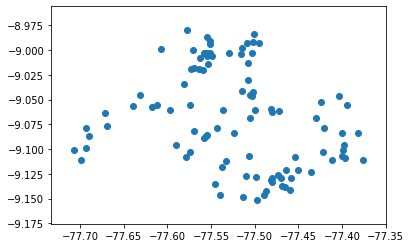

In [27]:
apointlist = np.array(pointlist)
print(apointlist[0])
plt.scatter(apointlist[:,0], apointlist[:,1])

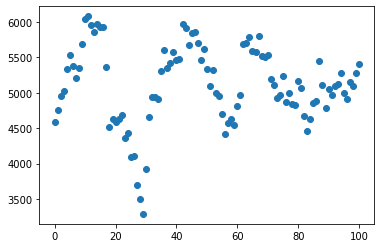

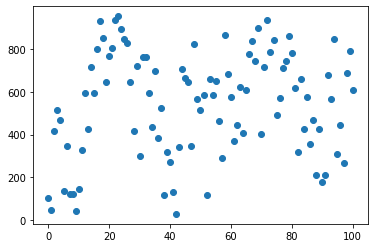

In [28]:
xx = [i for i in range(predictLen+1)]
elepre = [feet2m(apointlist[i][2]) for i in range(predictLen+1)]
propre = [feet2m(apointlist[i][3]) for i in range(predictLen+1)]
plt.scatter(xx, elepre)
plt.show()
plt.scatter(xx, propre)


## Evaluation

In [29]:
# compute distributions
df = addExtraColumns(df)
distributions = computeDistributions(df, diskRadius)

In [30]:
barColor  = (216/255, 226/255, 238/255, 1.0)
edgeColor = (137/255, 151/255, 168/255, 1.0)

def printHistogramsDistances(hbins, hReal, hSynth):
    hdiff = np.abs(hReal - hSynth)
    print('Max', np.max(hdiff), 'Sum', np.sum(hdiff), 'Avg', np.mean(hdiff))
    print('EMD', np.diff(hbins)[0]*np.abs(np.cumsum(hReal) - np.cumsum(hSynth)).sum())
    
def histogramsComparison(distribution, synthesisValues):
    hbins  = distribution['bins']
    hmids  = distribution['x']
    hReal  = distribution['hist']
    hSynth = histogramFromBins(synthesisValues, hbins, frequencies=False)
    hNorm  = np.round(synthesisValues.size * hReal/hReal.sum())

    fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(131)
    _ = ax.bar (hmids, hSynth, width=np.diff(hbins), color=barColor, edgecolor=edgeColor)
    _ = ax.plot(hmids, hNorm, color='r')

    ax = fig.add_subplot(132)
    _ = ax.bar (hmids, hNorm, width=np.diff(hbins), color='g')
    _ = ax.plot(hmids, hNorm, color='r')
    
    printHistogramsDistances(hbins, hReal/hReal.sum(), hSynth/hSynth.sum())
    print('Per bin differences (synthesis - target)')
    print(hSynth - hNorm)

Max 0.08521221090888653 Sum 0.9031164232790355 Avg 0.01075138599141709
EMD 539.3360622722636
Per bin differences (synthesis - target)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0. -1.  1. -1.
 -1.  0. -1. -1. -1. -3. -8. -7. -2. -3. -1. -9.  0.  9.  1.  4.  2.  5.
  4.  6.  3.  2.  3.  5.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


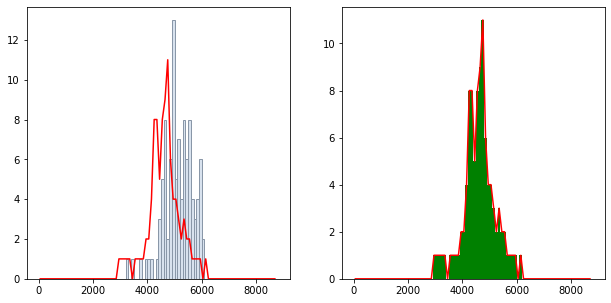

In [31]:
histogramsComparison(distributions['elevation'], np.array(elepre))

Max 0.3562951375553828 Sum 1.6111355695645249 Avg 0.03929598950157378
EMD 446.94212089137045
Per bin differences (synthesis - target)
[-36. -35.  -4.  -5.  -1.   1.   7.   2.   9.   4.   3.  10.   8.   7.
   7.   7.   8.   5.   3.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


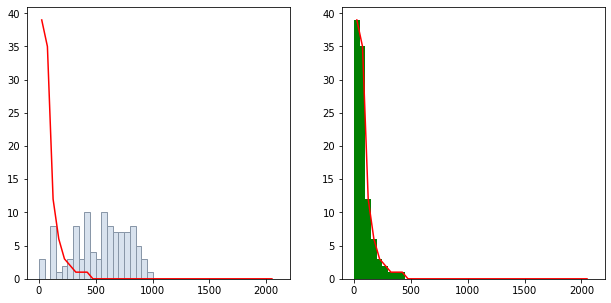

In [32]:
histogramsComparison(distributions['prominence'], np.array(propre))